     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512406 sha256=bcb21ad6b6431887dfe6c4b58aff58174dcfd3c60d9457e9768981e52076e48c
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d513c736bb93910277e1528ef4
Successfully built fastdtw
The file 'daily-min-temperatures.csv' has been successfully downloaded.


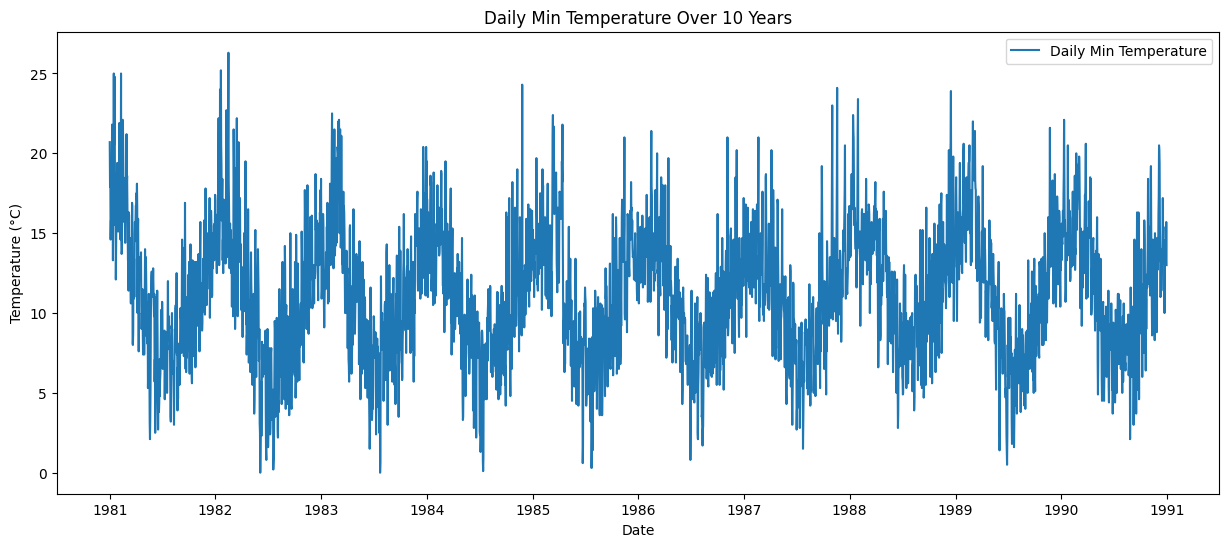

Epoch 1/100
57/57 - 1s - loss: 0.0517 - 602ms/epoch - 11ms/step
Epoch 2/100
57/57 - 0s - loss: 0.0122 - 101ms/epoch - 2ms/step
Epoch 3/100
57/57 - 0s - loss: 0.0109 - 95ms/epoch - 2ms/step
Epoch 4/100
57/57 - 0s - loss: 0.0099 - 94ms/epoch - 2ms/step
Epoch 5/100
57/57 - 0s - loss: 0.0093 - 95ms/epoch - 2ms/step
Epoch 6/100
57/57 - 0s - loss: 0.0090 - 97ms/epoch - 2ms/step
Epoch 7/100
57/57 - 0s - loss: 0.0088 - 93ms/epoch - 2ms/step
Epoch 8/100
57/57 - 0s - loss: 0.0088 - 115ms/epoch - 2ms/step
Epoch 9/100
57/57 - 0s - loss: 0.0086 - 102ms/epoch - 2ms/step
Epoch 10/100
57/57 - 0s - loss: 0.0086 - 99ms/epoch - 2ms/step
Epoch 11/100
57/57 - 0s - loss: 0.0085 - 100ms/epoch - 2ms/step
Epoch 12/100
57/57 - 0s - loss: 0.0086 - 95ms/epoch - 2ms/step
Epoch 13/100
57/57 - 0s - loss: 0.0086 - 104ms/epoch - 2ms/step
Epoch 14/100
57/57 - 0s - loss: 0.0084 - 93ms/epoch - 2ms/step
Epoch 15/100
57/57 - 0s - loss: 0.0084 - 99ms/epoch - 2ms/step
Epoch 16/100
57/57 - 0s - loss: 0.0083 - 103ms/epoch - 2m

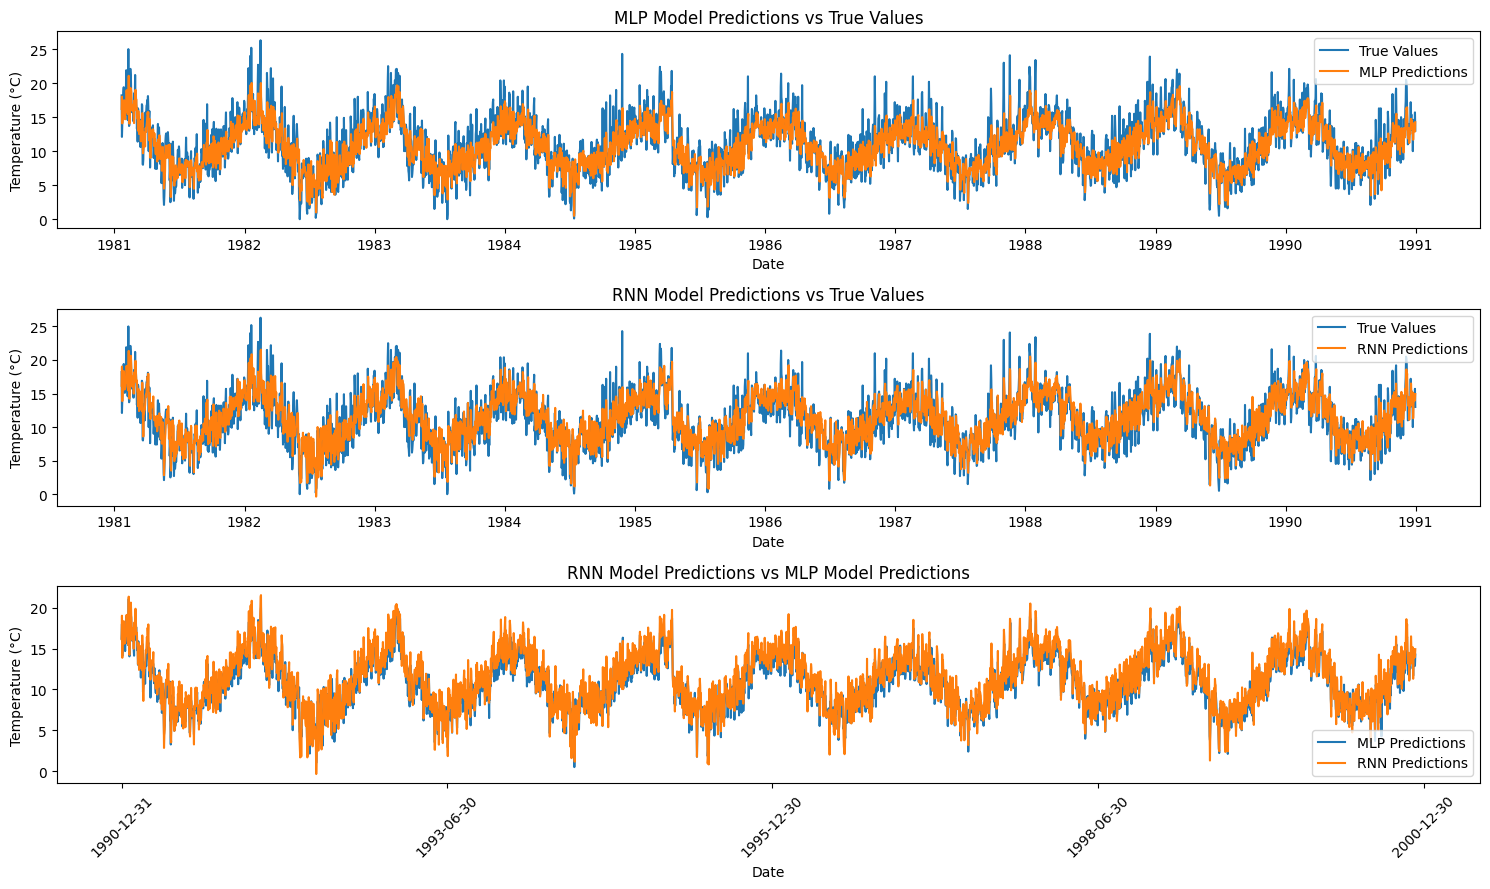

DTW Distance between MLP and RNN predictions: 3097.87


In [4]:
!pip install fastdtw
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fastdtw import fastdtw
from dtw import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

# Download and load the dataset using url
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
response = requests.get(url)

if response.status_code == 200:
    file_path = "daily-min-temperatures.csv"
    with open(file_path, "wb") as file:
        file.write(response.content)
    print(f"The file '{file_path}' has been successfully downloaded.")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')

# Visualize the data
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Temp'], label='Daily Min Temperature')
plt.title('Daily Min Temperature Over 10 Years')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

# Convert the dataframe to a numpy array
data = df.values.astype('float32')

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Function to prepare data for time series forecasting
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

# Set the random seed for reproducibility
np.random.seed(42)

# Set the look-back period
look_back = 20

# Prepare the dataset
X, Y = create_dataset(data_scaled, look_back)

# Use all the data for training and no validation split
X_train, Y_train = X, Y

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Multilayer Neural Network (MLP) model
mlp_model = Sequential()
mlp_model.add(Dense(100, input_dim=look_back, activation='relu'))
mlp_model.add(Dense(1))
mlp_model.compile(loss='mean_squared_error', optimizer='adam')
mlp_model.fit(X_train, Y_train, epochs=100, batch_size=64, verbose=2)

# Predictions on the entire dataset
mlp_predictions = mlp_model.predict(X_train)
mlp_predictions = scaler.inverse_transform(mlp_predictions)

# Recurrent Neural Network (RNN) model
rnn_model = Sequential()
rnn_model.add(SimpleRNN(100, input_shape=(X_train.shape[1], 1), activation='relu'))
rnn_model.add(Dense(1))
rnn_model.compile(loss='mean_squared_error', optimizer='adam')
rnn_model.fit(X_train, Y_train, epochs=100, batch_size=64, verbose=2)

# Predictions on the entire dataset
rnn_predictions = rnn_model.predict(X_train)
rnn_predictions = scaler.inverse_transform(rnn_predictions)

# Evaluate and compare model performance
mlp_mae = mean_absolute_error(data[look_back:, 0], mlp_predictions[:, 0])
rnn_mae = mean_absolute_error(data[look_back:, 0], rnn_predictions[:, 0])

mlp_rmse = np.sqrt(mean_squared_error(data[look_back:, 0], mlp_predictions[:, 0]))
rnn_rmse = np.sqrt(mean_squared_error(data[look_back:, 0], rnn_predictions[:, 0]))

print(f'MLP Mean Absolute Error (MAE): {mlp_mae:.2f}')
print(f'RNN Mean Absolute Error (MAE): {rnn_mae:.2f}')
print(f'MLP Root Mean Squared Error (RMSE): {mlp_rmse:.2f}')
print(f'RNN Root Mean Squared Error (RMSE): {rnn_rmse:.2f}')

# Plotting
plt.figure(figsize=(15, 9))

plt.subplot(3, 1, 1)
plt.plot(df.index[look_back:], data[look_back:, 0], label='True Values')
plt.plot(df.index[look_back:], mlp_predictions[:, 0], label='MLP Predictions')
plt.title('MLP Model Predictions vs True Values')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(df.index[look_back:], data[look_back:, 0], label='True Values')
plt.plot(df.index[look_back:], rnn_predictions[:, 0], label='RNN Predictions')
plt.title('RNN Model Predictions vs True Values')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()

# Plot predictions for the next 10 years
plt.subplot(3, 1, 3)
future_index = pd.date_range(start=df.index.max(), periods=len(mlp_predictions), freq='D')
plt.plot(future_index, mlp_predictions[:, 0], label='MLP Predictions')
plt.plot(future_index, rnn_predictions[:, 0], label='RNN Predictions')
plt.title('RNN Model Predictions vs MLP Model Predictions')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()

# Set x-axis ticks for every 2.5 years for the next 10 years
ticks_future = pd.date_range(start=df.index.max(), periods=5, freq=pd.DateOffset(years=2, months=6))
plt.xticks(ticks_future, [t.strftime('%Y-%m-%d') for t in ticks_future], rotation=45)

plt.tight_layout()
plt.show()

# Extract the predictions for the last 10 years for both models
mlp_predictions_last_10_years = mlp_predictions[-len(future_index):, 0]
rnn_predictions_last_10_years = rnn_predictions[-len(future_index):, 0]

# Calculate DTW distance using fastdtw
distance, path = fastdtw(mlp_predictions_last_10_years, rnn_predictions_last_10_years)

print(f'DTW Distance between MLP and RNN predictions: {distance:.2f}')
